In [ ]:
import warnings
warnings.filterwarnings("ignore")

# importing the required packages
import os
import gc
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import medfilt

In [ ]:
# changing directory and verifying
%cd /content/drive/MyDrive/DISC_Files/with_cell
!ls -v

/content/drive/MyDrive/DISC_Files/with_cell
111.csv  142.csv  223.csv  263.csv  333.csv  414.csv  438.csv  463.csv	529.csv  556.csv   3311.csv
112.csv  143.csv  224.csv  264.csv  334.csv  415.csv  439.csv  464.csv	531.csv  557.csv   4110.csv
113.csv  144.csv  225.csv  311.csv  335.csv  416.csv  441.csv  465.csv	532.csv  561.csv   4111.csv
114.csv  151.csv  226.csv  312.csv  336.csv  417.csv  442.csv  466.csv	533.csv  562.csv   4210.csv
115.csv  152.csv  227.csv  313.csv  337.csv  418.csv  443.csv  467.csv	534.csv  563.csv   4211.csv
116.csv  153.csv  231.csv  314.csv  338.csv  419.csv  444.csv  511.csv	535.csv  564.csv   4310.csv
117.csv  154.csv  232.csv  315.csv  339.csv  421.csv  445.csv  512.csv	536.csv  565.csv   4311.csv
121.csv  161.csv  233.csv  316.csv  341.csv  422.csv  446.csv  513.csv	537.csv  566.csv   4410.csv
122.csv  162.csv  234.csv  317.csv  342.csv  423.csv  447.csv  514.csv	538.csv  567.csv   4411.csv
123.csv  163.csv  235.csv  318.csv  343.csv  424.csv  448.csv  51

In [ ]:
# initializing empty dataframes
corr_df = pd.DataFrame(columns=['Filename',
                                'n',
                                '405 vs 488',
                                '488 vs 633',
                                '405 vs 633',
                                '488 vs (405 - 633)',
                                '405 vs 488 (p)',
                                '488 vs 633 (p)',
                                '405 vs 633 (p)',
                                '488 vs (405 - 633) (p)'])

In [ ]:
# function to do the following:
# creating a ‘label_modified’ column based on the original ‘label’ column.
# if there are 18 consecutive points with 1, it is retained as 1, otherwise, it is changed to 0.
# this is faster than the previous for loops since it uses numpy vectorization
def modify_data(df):

    # make groups
    df['group'] = (df['label'] != df['label'].shift()).cumsum()

    # cummulative count for each group
    df['counter'] = df.groupby('group').cumcount() + 1

    # mark the rows with the cummulative count >= K and label = 1 as True
    df['label_modified'] = (df['label'] == 1) & (df['counter'] >= 18)

    # for each group - check if any of the row is marked as 1, if so, mark all the rows in the group as True, then convert the whole column to 1/0
    df['label_modified'] = df.groupby('group')['label_modified'].transform('any').astype(int)

    # drop intermediate columns
    df.drop(['group', 'counter'], axis=1, inplace=True)

    return df

In [ ]:
# median filter
# it works by replacing each data point in a signal with the median value within a specified window around that data point.
def noise_filter(df, window_size):

  df['405'] = medfilt(df['405'], kernel_size=window_size)
  df['488'] = medfilt(df['488'], kernel_size=window_size)
  df['633'] = medfilt(df['633'], kernel_size=window_size)

  return df

In [ ]:
# function to calculate the correlations
def calc_correlation(df_0, df_1):

  v1 = df_0['405'].corr(df_0['488'])
  v2 = df_0['488'].corr(df_0['633'])
  v3 = df_0['405'].corr(df_0['633'])
  v4 = df_0['488'].corr(df_0['405'] - df_0['633'])

  if 1 in df_0['label_modified'].values:
    v1, v2, v3, v4 = 'NULL', 'NULL', 'NULL', 'NULL'

  v5 = df_1['405'].corr(df_1['488'])
  v6 = df_1['488'].corr(df_1['633'])
  v7 = df_1['405'].corr(df_1['633'])
  v8 = df_1['488'].corr(df_1['405'] - df_1['633'])

  return v1, v2, v3, v4, v5, v6, v7, v8

In [ ]:
index_x = 0

# read files (adjust the range as required)
for i in range(111, 5312):

  filename = f"{i}.csv"
  if os.path.exists(filename):

    # clear memory
    if 'data' in locals():
      del data
      gc.collect()

    # defining column names
    column_names = ['405', '488', '633', 'red', 'green', 'label']

    # define data types for each column - this makes reading faster since python does not have to infer the data type of each column (only slight improvement)
    dtypes = {'405': 'float64', '488': 'float64', '633': 'float64', 'red': 'float64', 'green': 'float64', 'label': 'int64'}

    print(f'Reading in {filename}')
    data = pd.read_csv(filename, header=None, names=column_names, dtype=dtypes)

    # shape of the data
    print(f'Shape of the data is: {data.shape}')

    # with K = 18, create modified label column
    df = modify_data(data)
    # apply the moise filter
    df = noise_filter(df, 9)

    # extracting all sets of 1s into separate groups (each group represents an occurence of a peak)
    df['group'] = (df['label_modified'] != df['label_modified'].shift()).cumsum()
    df_1 = df[df['label_modified'] == 1]
    df_1_groups = df_1.groupby('group')

    # for each group created above, extracting data of equal size with 0s right above an occurence of a peak
    for group_num, group_data_1 in df_1_groups:
      print(group_data_1.shape)
      print('-----')
      index_1_start = group_data_1.index[0]
      index_0_start = group_data_1.index[0] - group_data_1.shape[0]
      group_data_0 = df.loc[index_0_start : index_1_start - 1, ]

      # calculate the correlation for the following: 405 vs 488 ; 488 vs 633 ; 405 vs 633 for without and with peaks
      v1, v2, v3, v4, v5, v6, v7, v8 = calc_correlation(group_data_0, group_data_1)

      # store the values in a dataframe
      corr_df.loc[index_x] = [i, group_data_1.shape[0], v1, v2, v3, v4, v5, v6, v7, v8]
      index_x = index_x + 1

      # clear memory
      del group_data_0, group_data_1
      gc.collect()

Reading in 111.csv
Shape of the data is: (5400000, 6)
(23, 8)
-----
(22, 8)
-----
(18, 8)
-----
(19, 8)
-----
(18, 8)
-----
Reading in 112.csv
Shape of the data is: (5400000, 6)
(26, 8)
-----
(19, 8)
-----
(20, 8)
-----
(29, 8)
-----
(19, 8)
-----
(19, 8)
-----
(18, 8)
-----
(18, 8)
-----
(20, 8)
-----
(21, 8)
-----
(26, 8)
-----
Reading in 113.csv
Shape of the data is: (5400000, 6)
(18, 8)
-----
(23, 8)
-----
(19, 8)
-----
(26, 8)
-----
(22, 8)
-----
(20, 8)
-----
(19, 8)
-----
(33, 8)
-----
(18, 8)
-----
(20, 8)
-----
(19, 8)
-----
(19, 8)
-----
(21, 8)
-----
(19, 8)
-----
Reading in 114.csv
Shape of the data is: (5400000, 6)
(23, 8)
-----
(27, 8)
-----
(26, 8)
-----
(18, 8)
-----
(25, 8)
-----
(29, 8)
-----
(18, 8)
-----
(19, 8)
-----
(19, 8)
-----
(18, 8)
-----
(23, 8)
-----
(19, 8)
-----
Reading in 115.csv
Shape of the data is: (5400000, 6)
(19, 8)
-----
(18, 8)
-----
(18, 8)
-----
(20, 8)
-----
(24, 8)
-----
(19, 8)
-----
(18, 8)
-----
(19, 8)
-----
(19, 8)
-----
(20, 8)
-----
Re

In [ ]:
# write into a file
corr_df.to_csv('/content/drive/MyDrive/DISC_Files/pearson_correlations_with_equal_n_and_nf.csv', index=False)

In [ ]:
# reading in the correlation file - pearson_correlations_with_equal_n.csv
corr_df = pd.read_csv('/content/drive/MyDrive/DISC_Files/pearson_correlations_with_equal_n_and_nf.csv')
corr_df.head()

,Filename,n,405 vs 488,488 vs 633,405 vs 633,488 vs (405 - 633),405 vs 488 (p),488 vs 633 (p),405 vs 633 (p),488 vs (405 - 633) (p)
0,111.0,23.0,0.354616,0.777630,-0.133970,-0.653793,0.703465,0.866250,0.704819,0.575821
1,111.0,22.0,0.154425,0.903505,0.204284,-0.900654,0.432378,0.866269,0.517510,-0.712548
2,111.0,18.0,0.878663,0.061230,-0.148005,0.514320,0.018290,0.808980,-0.519861,-0.132462
3,111.0,19.0,0.839541,0.895207,0.841448,-0.879005,0.501226,0.639159,-0.151214,0.261821
4,111.0,18.0,-0.772140,0.880829,-0.825689,-0.877357,-0.386988,0.747016,-0.313732,-0.642296


In [ ]:
# print the minimum values of each column
print("Minimum values:")
print(corr_df.min().to_string(float_format="{:.2f}".format))

# print the maximum values of each column
print("\nMaximum values:")
print(corr_df.max().to_string(float_format="{:.2f}".format))

Minimum values:
Filename                 111.00
n                         18.00
405 vs 488                -0.98
488 vs 633                -0.80
405 vs 633                -0.98
488 vs (405 - 633)        -0.99
405 vs 488 (p)            -0.99
488 vs 633 (p)            -0.90
405 vs 633 (p)            -0.97
488 vs (405 - 633) (p)    -0.99

Maximum values:
Filename                 5310.00
n                          96.00
405 vs 488                  1.00
488 vs 633                  1.00
405 vs 633                  1.00
488 vs (405 - 633)          1.00
405 vs 488 (p)              0.98
488 vs 633 (p)              1.00
405 vs 633 (p)              0.98
488 vs (405 - 633) (p)      0.98


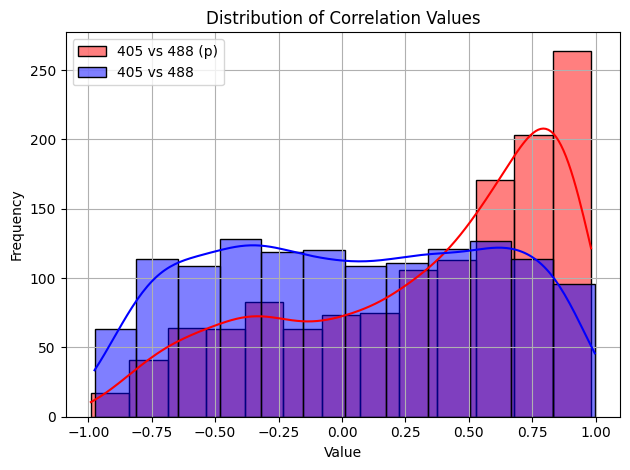

In [ ]:
# 405 v 488
# plotting the histogram for 405 vs 488 (p) correlations
sns.histplot(data=corr_df, x='405 vs 488 (p)', kde=True, color='red', label='405 vs 488 (p)')

# plotting the histogram for 405 vs 488 correlations
sns.histplot(data=corr_df, x='405 vs 488', kde=True, color='blue', label='405 vs 488')

# setting labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Correlation Values')
plt.grid(True)

# adding legend
plt.legend()

plt.tight_layout()
plt.show()

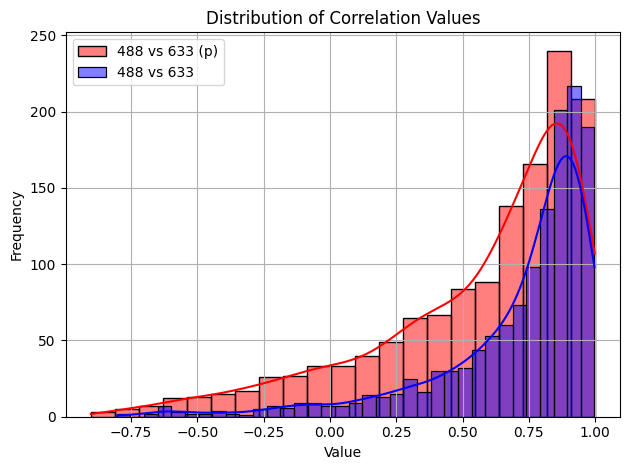

In [ ]:
# 488 vs 633
# plotting the histogram for 488 vs 633 (p) correlations
sns.histplot(data=corr_df, x='488 vs 633 (p)', kde=True, color='red', label='488 vs 633 (p)')

# plotting the histogram for 488 vs 633 correlations
sns.histplot(data=corr_df, x='488 vs 633', kde=True, color='blue', label='488 vs 633')

# setting labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Correlation Values')
plt.grid(True)

# adding legend
plt.legend()

plt.tight_layout()
plt.show()

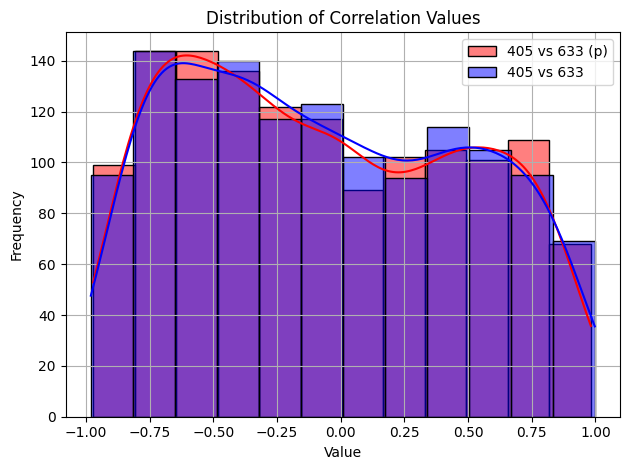

In [ ]:
# 405 vs 633
# plotting the histogram for 405 vs 633 (p) correlations
sns.histplot(data=corr_df, x='405 vs 633 (p)', kde=True, color='red', label='405 vs 633 (p)')

# plotting the histogram for 405 vs 633 correlations
sns.histplot(data=corr_df, x='405 vs 633', kde=True, color='blue', label='405 vs 633')

# setting labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Correlation Values')
plt.grid(True)

# adding legend
plt.legend()

plt.tight_layout()
plt.show()

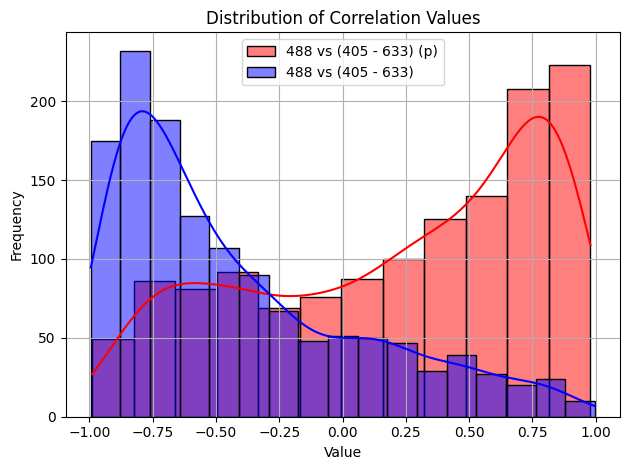

In [ ]:
# 488 vs (405 - 633)
# plotting the histogram for 488 vs (405 - 633) (p) correlations
sns.histplot(data=corr_df, x='488 vs (405 - 633) (p)', kde=True, color='red', label='488 vs (405 - 633) (p)')

# plotting the histogram for 488 vs (405 - 633) correlations
sns.histplot(data=corr_df, x='488 vs (405 - 633)', kde=True, color='blue', label='488 vs (405 - 633)')

# setting labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Correlation Values')
plt.grid(True)

# adding legend
plt.legend()

plt.tight_layout()
plt.show()